In [1]:
#Sources: https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from collections import defaultdict
import json
from matplotlib import pyplot as plt
import numpy as np

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


#function to scrape the website and return as dictionary
def scrape_morningstar(url): 

  #empty tables to add scraped data to:

  stock_price = []

  page = requests.get(url)

  soup = BeautifulSoup(page.content, 'html.parser')

  span_symbol = soup.find_all('span', class_ = 'mdc-data-point mdc-data-point--string')
  span_price = soup.find_all('span', class_ = 'mdc-data-point mdc-data-point--number')

  string_list = [] #empty list to append the data 
  for x in span_symbol:
    string_list.append(x.get_text())

  for x in span_price:
    stock_price.append(x.get_text())


  #splitting the list into two and keeping 50 values only
  company_name = string_list[:100:2] 
  symbol = string_list[1:100:2] 

  stock_price = stock_price[:200:4]# slicing the list to only keep the needed elements

  small_cap_dict = {'Symbol': symbol, 'Name': company_name, 'Price': stock_price}

  return small_cap_dict

url1 = 'https://www.morningstar.com/small-cap-value-stocks'

d1 = scrape_morningstar(url1)


In [3]:
#function to scrape the website and return as dictionary
def scrape_tradingview(url):

  page = requests.get(url)

  soup = BeautifulSoup(page.content, 'html.parser')

  span_name = soup.find_all('span', class_ = 'tv-screener__description')
  a_symbol = soup.find_all('a', class_ = 'tv-screener__symbol')
  span_price = soup.findAll('td', {'class':['tv-data-table__cell', 'tv-screener-table__cell', 'tv-screener-table__cell--big', 'tv-screener-table__cell--with-marker']})

  #empty lists to append data to
  name = [] 
  symbol = []
  price = []

  for x in span_name:
      name.append(x.get_text().strip())

  for x in a_symbol:
      symbol.append(x.get_text().strip())

  for x in span_price:
      price.append(x.get_text().strip())

  symbol = symbol[20:70:2] #slicing list to keep only the 25 first values and removing unnecesary values
  name = name[10:35] # slicing list to keep only the 25 first values
  price = price[121:416:12]  # slicing list to keep only the 25 first values and removing unnecesary values

  large_cap_dict1 = {'Symbol': symbol, 'Name': name, 'Price': price}

  return large_cap_dict1

url2 = 'https://www.tradingview.com/markets/stocks-usa/market-movers-large-cap/'


d2 = scrape_tradingview(url2)


In [4]:
#function to scrape the website and return as dictionary
def scrape_companies_market_cap(url):

  page = requests.get(url)

  soup = BeautifulSoup(page.content, 'html.parser')

  div_name = soup.find_all('div', class_ = 'company-name')
  div_symbol = soup.find_all('div', class_ = 'company-code')
  div_price = soup.find_all('td', {'class':['td-right', 'pt-2']})

  #div_price = soup.find_all('div', class_ = 'price')

  #empty lists to append data to
  name = [] 
  symbol = []
  price = []

  for x in div_name:
        name.append(x.get_text())

  for x in div_symbol:
        symbol.append(x.get_text())

  for x in div_price:
        price.append(x.get_text())


  #sciling tables to get 25 values and removing unnecessary values
  name = name[50:75]
  symbol= symbol[50:75]
  price = price[152:227:3] 
  price = [s.replace("$", "") for s in price]

  large_cap_dict2 = {'Symbol': symbol, 'Name': name, 'Price': price}
  return large_cap_dict2

url3 = 'https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/'

d3 = scrape_companies_market_cap(url3)

In [5]:
#creating df's from dictionaries:

df1 = pd.DataFrame(d1)
df2 = pd.DataFrame(d2)
df3 = pd.DataFrame(d3)

DF1 = pd.concat([df1, df2], axis=0)
DF1 = pd.concat([DF1, df3], axis=0)

DF1.reset_index(inplace = True)
del DF1['index'] # removing unnecessary column

In [6]:
#making API calls

key = '7LLF76SWKUB2XO17'
stock_dict = {} # emptly dict to append data from the table

for t in DF1["Symbol"]:
  url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={t}&apikey={key}'
  r = requests.get(url)
  data = r.json()
  if r.status_code==200:
    stock_dict[t] = data['annualReports'][0]
    time.sleep(0.8) # 75 requests per minute allowed 
  else:
    print("Failed API request")

In [7]:
#creating a dataframe to hold API data and editing it keeping only the necessary columns
DF2 = pd.DataFrame(stock_dict)
DF2 = DF2.T
DF2 = DF2.drop(columns=['reportedCurrency', 'fiscalDateEnding', 'totalRevenue', 'costOfRevenue', 'costofGoodsAndServicesSold', 'operatingIncome', 'sellingGeneralAndAdministrative', 'researchAndDevelopment', 'investmentIncomeNet', 'netInterestIncome', 'interestIncome', 'interestExpense', 'nonInterestIncome', 'otherNonOperatingIncome', 'depreciation', 'depreciationAndAmortization', 'incomeBeforeTax', 'incomeTaxExpense', 'interestAndDebtExpense', 'netIncomeFromContinuingOperations', 'comprehensiveIncomeNetOfTax', 'ebit', 'ebitda'])
DF2.index.rename('Symbol', inplace=True)
DF2 = DF2.rename(columns={'grossProfit': 'Gross Profit', 'operatingExpenses': 'Operating Expenses', 'netIncome': 'Net Income'})


In [8]:
# Merging the two dataframes into a third dataframe that will contain information from both DF1 and DF2.

DF3 = pd.merge(DF1, DF2, on='Symbol', how='inner') #combining two dataframes

DF3.to_csv('project2data.csv') # saving data in csv format

DF3 = pd.read_csv('project2data.csv', index_col=0)
#pd.set_option('max_columns', None)
pd.options.display.max_columns =None
print(DF3.head(10)) #displaying the first 10 rows of combined df
print()
print()
DF3.describe().apply(lambda s: s.apply('{0:.2f}'.format)) #displaying desctiptive statistics


  Symbol                                             Name  Price  \
0   SRCE                                  1st Source Corp  47.99   
1   ETNB                        89bio Inc Ordinary Shares  12.40   
2    AIR                                         AAR Corp  37.15   
3   ABEO                          Abeona Therapeutics Inc   0.33   
4    ABM                               ABM Industries Inc  40.41   
5   ACTG                             Acacia Research Corp   4.96   
6    ASO  Academy Sports and Outdoors Inc Ordinary Shares  40.17   
7   ACCO                                 ACCO Brands Corp   8.01   
8   ACRX                       AcelRx Pharmaceuticals Inc   0.59   
9   ACER                            Acer Therapeutics Inc   2.24   

   Gross Profit  Operating Expenses  Net Income  
0     107926000            15969000    81437000  
1     -13386000            49355000   -49499000  
2     275900000           222000000    35800000  
3     -22109000            91420000   -84234000  
4

,Price,Gross Profit,Operating Expenses,Net Income
count,100.00,100.00,100.00,100.00
mean,143.50,71675725470.08,37349790221.74,31700545259.40
std,194.52,487609450975.82,263880527373.31,229811499597.24
min,0.33,-10182000000.00,-26548000.00,-22440000000.00
25%,9.89,6050664.00,76602025.00,-25375336.75
50%,59.94,1490738000.00,2064412000.00,146351500.00
75%,183.71,18103500000.00,11363250000.00,5848250000.00
max,910.87,4832373000000.00,2634625000000.00,2245261000000.00


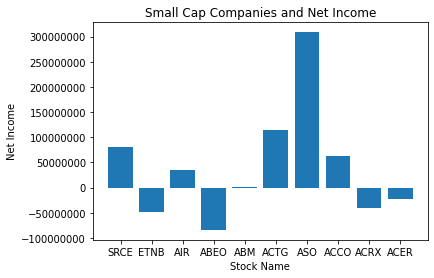

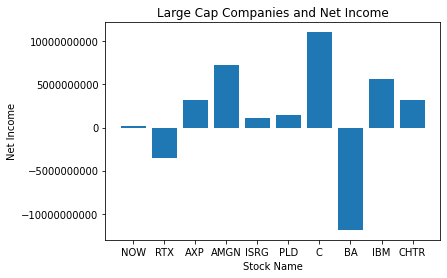

In [9]:
#creating Data Visualisation graphs:

#Graph 1 for small cap stocks
small_name = d1['Symbol'][0:10]
small_price = d1['Price'][0:10]

#converting items into a list of floats for correct display in graphs:
small_price_n = []
for item in small_price:
    small_price_n.append(float(item))

small_ni = DF3['Net Income'][0:10].to_list()

plt.bar(small_name, small_ni)

plt.title("Small Cap Companies and Net Income")
plt.xlabel("Stock Name")
plt.ylabel('Net Income')
plt.ticklabel_format(style='plain', axis='y') #removing scientific notation from the graph
plt.show()
print()


#Graph 2 for large cap stocks
large_name = d3['Symbol'][15:25]
large_price = d3['Price'][15:25]
large_ni = DF3['Net Income'][90:100].to_list()

#converting items into a list of floats for correct display in graphs:
large_price_n = []
for item in large_price:
    large_price_n.append(float(item))


plt.bar(large_name, large_ni)

plt.title("Large Cap Companies and Net Income")
plt.xlabel("Stock Name")
plt.ylabel('Net Income')
plt.ticklabel_format(style='plain', axis='y') #removing scientific notation from the graph
plt.show()

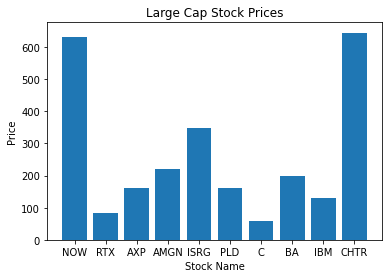

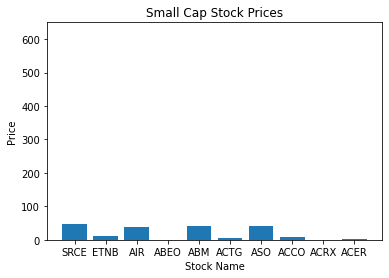

In [10]:
#Graph 2 for large cap stocks

plt.bar(large_name, large_price_n)

plt.title("Large Cap Stock Prices")
plt.xlabel("Stock Name")
plt.ylabel('Price')
plt.show()
print()

#Graph 2 for small cap stocks
plt.bar(small_name, small_price_n)

plt.title("Small Cap Stock Prices")
plt.xlabel("Stock Name")
plt.ylabel('Price')
ax = plt.gca()
ax.set_ylim([0, 650])
plt.show()


